# AAI-530 Final Project Group 5

## Smart EV Charging Network Optimization System

### Dataset Preparation and Cleaning

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from dateutil import parser

# Load dataset
df = pd.read_csv('station_data_dataverse.csv')

# Inspect initial data
print("Initial Data Sample:\n", df.head())
print("\nDataset Columns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)

# Fix malformed dates ('0014' to '2014')
df['created_fixed'] = df['created'].astype(str).apply(lambda x: x.replace('0014', '2014') if x.startswith('0014') else x)

# Convert 'created_fixed' to datetime
df['created_parsed'] = pd.to_datetime(df['created_fixed'], errors='coerce')

# Debug: Verify date parsing
print("\nDate Conversion Check:\n", df[['created', 'created_fixed', 'created_parsed']].head())

# Drop rows with unparseable dates
df = df.dropna(subset=['created_parsed'])

# Check for missing or zero energy consumption
missing_kwh = df['kwhTotal'].isnull().sum()
zero_kwh = (df['kwhTotal'] == 0).sum()

print(f"\nMissing 'kwhTotal': {missing_kwh}")
print(f"Zero values in 'kwhTotal': {zero_kwh}")

# Drop rows with missing or zero kWh
df = df.dropna(subset=['kwhTotal'])
df = df[df['kwhTotal'] > 0]

Initial Data Sample:
    sessionId  kwhTotal  dollars              created                ended  \
0    1366563      7.78     0.00  0014-11-18 15:40:26  0014-11-18 17:11:04   
1    3075723      9.74     0.00  0014-11-19 17:40:26  0014-11-19 19:51:04   
2    4228788      6.76     0.58  0014-11-21 12:05:46  0014-11-21 16:46:04   
3    3173284      6.17     0.00  0014-12-03 19:16:12  0014-12-03 21:02:18   
4    3266500      0.93     0.00  0014-12-11 20:56:11  0014-12-11 21:14:06   

   startTime  endTime  chargeTimeHrs weekday platform  ...  managerVehicle  \
0         15       17       1.510556     Tue  android  ...               0   
1         17       19       2.177222     Wed  android  ...               0   
2         12       16       4.671667     Fri  android  ...               0   
3         19       21       1.768333     Wed  android  ...               0   
4         20       21       0.298611     Thu  android  ...               0   

   facilityType  Mon  Tues  Wed  Thurs  Fri  S

### IoT System Design/Architecture

**System Components:**

**Sensors:**
- Location: Embedded in EV charging stations.
- Type: Power meters for energy consumption, session logs for user data.
- Limitations: Dependent on network stability and sensor calibration.

**Edge Processing:**
- Purpose: Filter noisy data, conduct initial preprocessing.
- Hardware: Raspberry Pi or similar lightweight devices.
- Impact: Reduces data sent to the cloud, improving efficiency.

**Networking:**
- Protocols: MQTT for lightweight communication, Wi-Fi/5G for data transmission.
- Reliability: Redundant systems to handle network failures.

**Data Storage and Processing:**
- Tools: AWS S3 for storage, AWS Lambda for serverless data processing.
- Scalability: Use of distributed cloud databases like AWS DynamoDB.
- ML Insights: Run models in AWS SageMaker or Google Cloud AI for scalability.

### Data Processing and Insights
- Exploratory Data Analysis (EDA)


Summary Statistics:
           sessionId   kwhTotal    dollars  startTime    endTime  \
count  2.300000e+01  23.000000  23.000000  23.000000  23.000000   
mean   4.839265e+06   5.270870   0.054348  16.608696  18.826087   
min    1.366563e+06   0.300000   0.000000  12.000000  15.000000   
25%    3.219892e+06   2.095000   0.000000  15.000000  16.500000   
50%    4.228788e+06   6.640000   0.000000  17.000000  19.000000   
75%    6.607835e+06   7.030000   0.000000  18.500000  21.000000   
max    8.490014e+06   9.740000   0.670000  20.000000  22.000000   
std    1.928126e+06   2.859617   0.180575   2.369103   2.405527   

       chargeTimeHrs   distance        userId      stationId     locationId  \
count      23.000000  11.000000  2.300000e+01      23.000000      23.000000   
mean        2.224167  20.695727  3.347301e+07  431235.565217  504559.347826   
min         0.179167  20.695727  3.082810e+07  129465.000000  202527.000000   
25%         0.850833  20.695727  3.082810e+07  243741.5000

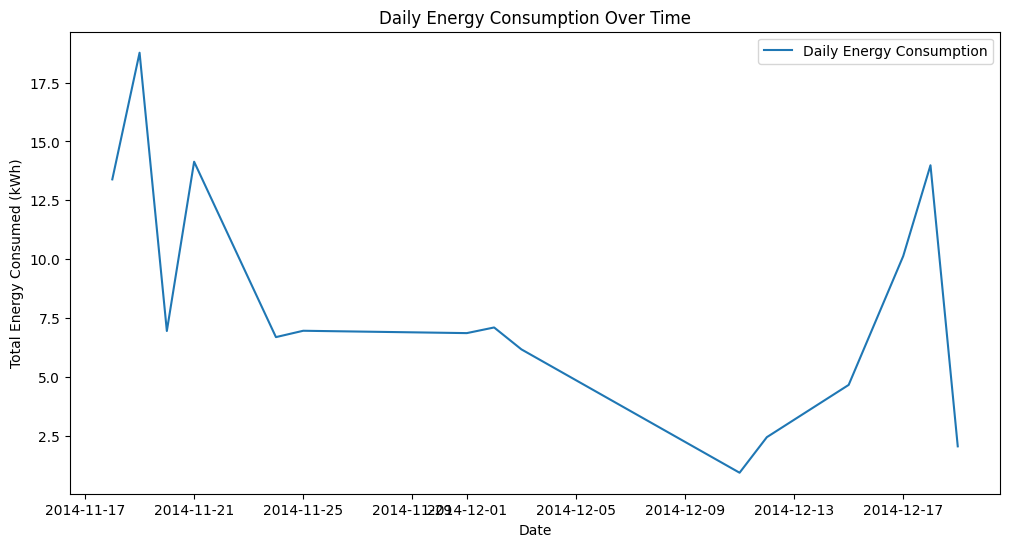

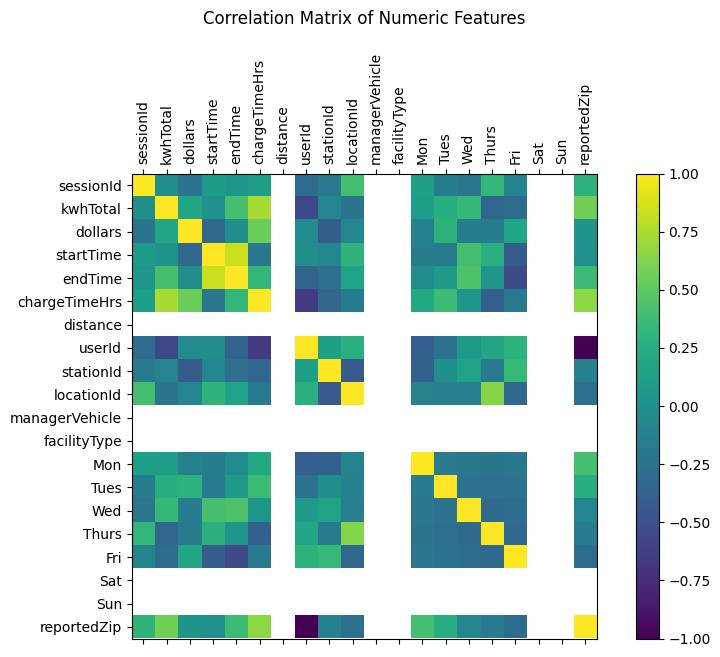

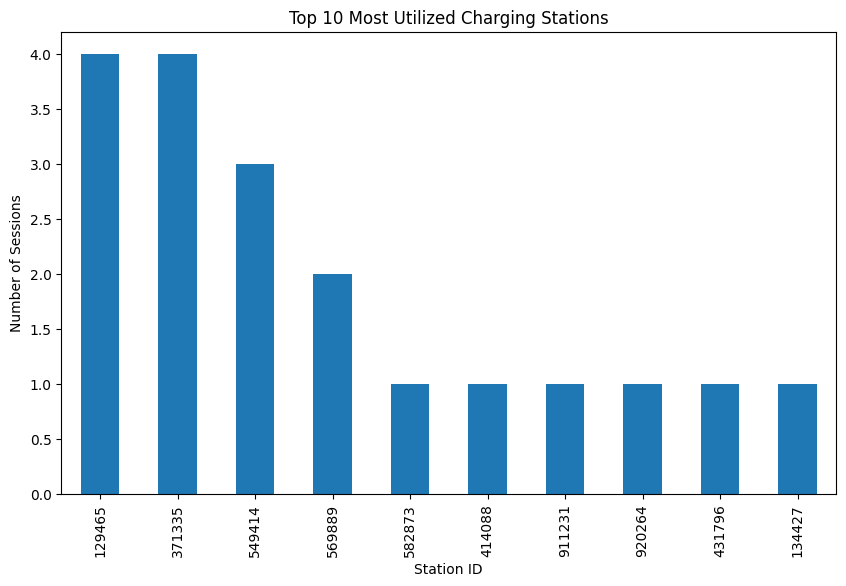

In [23]:
# Summary statistics
print("\nSummary Statistics:\n", df.describe())

# Energy consumption trends over time
df['date_only'] = df['created_parsed'].dt.date
daily_energy = df.groupby('date_only')['kwhTotal'].sum()

plt.figure(figsize=(12, 6))
plt.plot(daily_energy.index, daily_energy.values, label='Daily Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Total Energy Consumed (kWh)')
plt.title('Daily Energy Consumption Over Time')
plt.legend()
plt.show()

# Correlation analysis
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 6))
plt.matshow(correlation_matrix, fignum=1)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar()
plt.title('Correlation Matrix of Numeric Features', pad=20)
plt.show()

# Station utilization (most used charging stations)
station_usage = df['stationId'].value_counts().head(10)
plt.figure(figsize=(10, 6))
station_usage.plot(kind='bar')
plt.xlabel('Station ID')
plt.ylabel('Number of Sessions')
plt.title('Top 10 Most Utilized Charging Stations')
plt.show()

## Machine Learning Models
- We need two distinct models: a deep learning model and a time series prediction model.

### Model 1: Deep Learning Classification (Charging Speed Prediction)

C:\Users\Pete P\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2381 - loss: 1.1605 - val_accuracy: 0.6667 - val_loss: 1.0223
Epoch 2/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.2381 - loss: 1.1460 - val_accuracy: 0.8333 - val_loss: 0.9929
Epoch 3/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3810 - loss: 1.0727 - val_accuracy: 1.0000 - val_loss: 0.9657
Epoch 4/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5238 - loss: 1.0256 - val_accuracy: 1.0000 - val_loss: 0.9383
Epoch 5/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7143 - loss: 1.0102 - val_accuracy: 1.0000 - val_loss: 0.9111
Epoch 6/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.7143 - loss: 0.9494 - val_accuracy: 1.0000 - val_loss: 0.8827
Epoch 7/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.7143 - loss: 0.9474 - val_accuracy: 1.0000 - val_loss: 0.8540
Epoch 8/75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7619 - loss: 0.9309 - val_accuracy: 1.0000 - val_loss: 0.

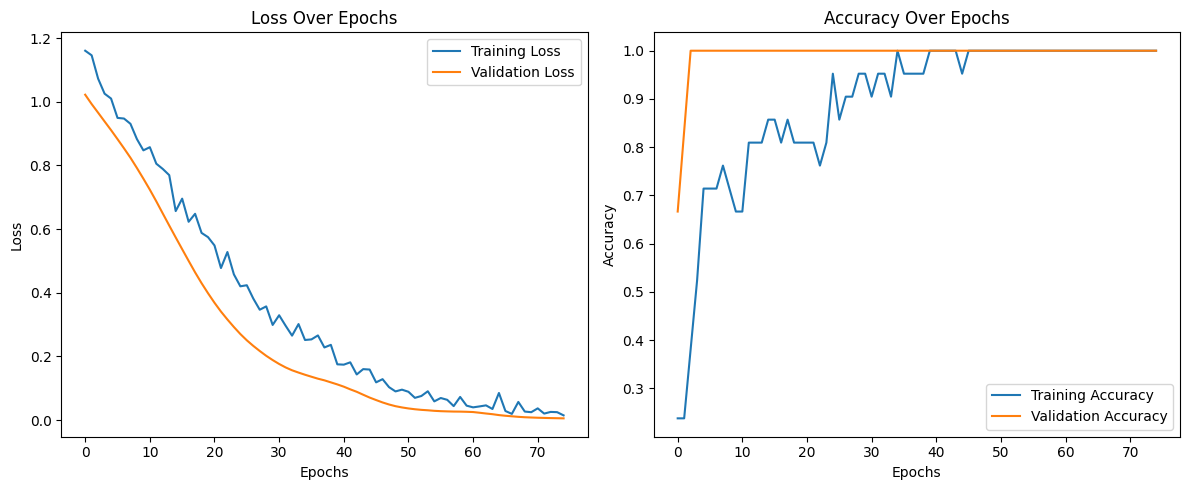

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


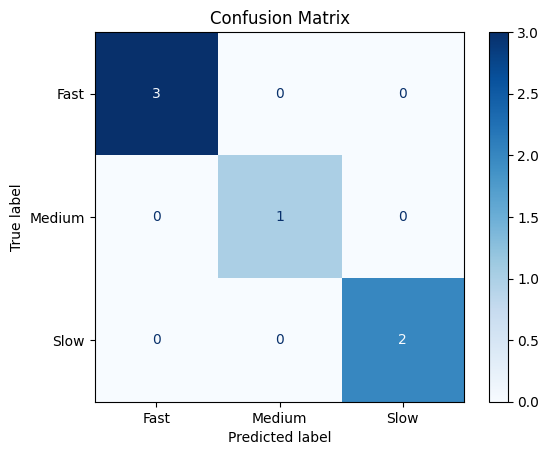

Classification Report:
               precision    recall  f1-score   support

        Fast       1.00      1.00      1.00         3
      Medium       1.00      1.00      1.00         1
        Slow       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



In [29]:
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Data Preparation
# Assuming the DataFrame 'df' is preloaded and cleaned
bins = [0, 1, 3, np.inf]
labels = ['Fast', 'Medium', 'Slow']
df['chargingCategory'] = pd.cut(df['chargeTimeHrs'], bins=bins, labels=labels)

# Feature Engineering
features = df[['sessionId', 'distance', 'chargeTimeHrs', 'facilityType', 'weekday', 'dollars']].copy()
target = df['chargingCategory']

# Encode categorical features
features['facilityType'] = LabelEncoder().fit_transform(features['facilityType'])
features['weekday'] = LabelEncoder().fit_transform(features['weekday'])
target_encoded = LabelEncoder().fit_transform(target)
target_categorical = to_categorical(target_encoded)

# Handle missing values
features.fillna(0, inplace=True)

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Handle Class Imbalance
smote = SMOTE(random_state=42)
features_balanced, target_balanced = smote.fit_resample(features_scaled, target_encoded)
target_categorical_balanced = to_categorical(target_balanced)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features_balanced, target_categorical_balanced, test_size=0.2, random_state=42)

# Compute Class Weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(target_balanced), y=target_balanced)
class_weights_dict = dict(enumerate(weights))

# Build Deep Learning Model
classifier_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # Output layer for 3 classes
])

classifier_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = classifier_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=75, batch_size=32, class_weight=class_weights_dict)

# Evaluate Model
loss, accuracy = classifier_model.evaluate(X_test, y_test)
print(f"Improved Classification Model Loss: {loss}")
print(f"Improved Classification Model Accuracy: {accuracy}")

# Visualization
# Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Confusion Matrix
y_pred = np.argmax(classifier_model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=labels))

### Model 2: Time Series Prediction - Charging Demand (LSTM)